In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
import networkx as nx
import random

In [3]:
# 设置设备
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # Corrected MPS check

print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Shuffle and divide data
num_agents = 10
indices = np.random.permutation(len(dataset))
split_indices = np.array_split(indices, num_agents)
subsets = [Subset(dataset, idx) for idx in split_indices]
dataloaders = [DataLoader(subset, batch_size=64, shuffle=True) for subset in subsets]

Using device: mps


In [4]:
def initialize_and_make_doubly_stochastic(num_agents, initial_graph_type="erdos_renyi", erdos_renyi_prob=0.5,
                                          tol=1e-5, max_iters=1000, device='cpu'):

    # 1. Create the initial graph
    if initial_graph_type == "erdos_renyi":
        G = nx.erdos_renyi_graph(num_agents, erdos_renyi_prob)
        while not nx.is_connected(G):
            G = nx.erdos_renyi_graph(num_agents, erdos_renyi_prob)
    elif initial_graph_type == "complete":
        G = nx.complete_graph(num_agents)
    else:
        print(f"Error: Invalid initial_graph_type: {initial_graph_type}")
        return None, None

    # 2. Get the adjacency matrix
    adj_matrix = nx.adjacency_matrix(G).toarray()

    # 3. Make it doubly stochastic (inner function for clarity)
    def _make_doubly_stochastic(matrix, tol, max_iters):
        A = matrix.copy().astype(np.float64)  # Work on a copy
        for _ in range(max_iters):
            new_A = A.copy()  # Create a *new* array for each iteration
            row_sums = new_A.sum(axis=1)
            if np.any(row_sums == 0):
                new_A[row_sums == 0, :] = 1 / new_A.shape[1]  # Correct indexing
                row_sums = new_A.sum(axis=1) #re calculate

            new_A = new_A / row_sums[:, np.newaxis]  # Divide by row sums

            col_sums = new_A.sum(axis=0)
            if np.any(col_sums == 0):
                new_A[:, col_sums == 0] = 1 / new_A.shape[0]  # Correct indexing
                col_sums = new_A.sum(axis=0) #re calculate

            new_A = new_A / col_sums  # Divide by column sums

            if np.allclose(new_A.sum(axis=1), 1, atol=tol) and np.allclose(new_A.sum(axis=0), 1, atol=tol):
                return new_A  # Return the new array
            A = new_A # update A
        print("Warning: Sinkhorn-Knopp did not converge within max_iters.")
        return A

    W = _make_doubly_stochastic(adj_matrix, tol, max_iters)

    # 4. Convert to PyTorch tensor
    W_tensor = torch.tensor(W, dtype=torch.float32).to(device)
    return G, W_tensor


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



def time_varying_graph(G, t, change_prob=0.3, tol=1e-5, max_iters=10000, device='cpu'):
    """Simulates a time-varying graph and returns updated graph and doubly stochastic matrix."""
    if t > 0:
        edges = list(G.edges())
        for edge in edges:
            if random.random() < change_prob:
                G.remove_edge(*edge)
        while not nx.is_connected(G):
            u, v = random.sample(range(G.number_of_nodes()), 2)
            G.add_edge(u, v)

    adj_matrix = nx.adjacency_matrix(G).toarray()

    def _make_doubly_stochastic(matrix, tol, max_iters):  # Inner function
        A = matrix.copy().astype(np.float64)  # Work on a copy
        for _ in range(max_iters):
            new_A = A.copy()  # Create a *new* array
            row_sums = new_A.sum(axis=1)
            if np.any(row_sums == 0):
                new_A[row_sums == 0, :] = 1 / new_A.shape[1] #correct indexing
                row_sums = new_A.sum(axis=1) #re calculate
            new_A = new_A / row_sums[:, np.newaxis]

            col_sums = new_A.sum(axis=0)
            if np.any(col_sums == 0):
                new_A[:, col_sums == 0] = 1 / new_A.shape[0] #correct indexing
                col_sums = new_A.sum(axis=0) # re calculate
            new_A = new_A / col_sums

            if np.allclose(new_A.sum(axis=1), 1, atol=tol) and np.allclose(new_A.sum(axis=0), 1, atol=tol):
                return new_A
            A = new_A # update A

        print("Warning: Sinkhorn-Knopp did not converge within max_iters.")
        return A

    W = _make_doubly_stochastic(adj_matrix, tol, max_iters)
    W_tensor = torch.tensor(W, dtype=torch.float32).to(device)
    return G, W_tensor



In [6]:
def run_model(epochs, num_agents, losses, models, criterions, learning_rate, use_time_varying_graph=False):

    # Initialize graph and W matrix
    if use_time_varying_graph:
        G, W = initialize_and_make_doubly_stochastic(num_agents, device=device)
    else:
        _, W = initialize_and_make_doubly_stochastic(num_agents, initial_graph_type="complete", device=device)

    for epoch in range(epochs):
        # --- Graph and W Matrix (Time-Varying) ---
        if use_time_varying_graph:
            G, W = time_varying_graph(G, epoch, device=device)

        # --- Parameter Averaging ---
        new_params = {}
        for i in range(num_agents):
            new_params[i] = {name: torch.zeros_like(param) for name, param in models[i].named_parameters()}
            for name, param in models[i].named_parameters():
                for j in range(num_agents):
                    new_params[i][name] += W[i, j] * models[j].state_dict()[name]

        for i in range(num_agents):
            for name, param in models[i].named_parameters():
                param.data.copy_(new_params[i][name])

        # --- Training Loop ---
        for i in range(num_agents):
            running_loss = 0.0
            for images, labels in dataloaders[i]:
                images, labels = images.to(device), labels.to(device)
                outputs = models[i](images)
                loss = criterions[i](outputs, labels)
                loss.backward()

                with torch.no_grad():
                    for param in models[i].parameters():
                        param -= learning_rate * param.grad
                    for param in models[i].parameters():
                        param.grad.zero_()
                running_loss += loss.item()
            losses[i].append(running_loss / len(dataloaders[i]))
            print(f"Agent {i+1}, Epoch {epoch+1}, Loss: {running_loss / len(dataloaders[i])}")


In [7]:
if __name__ == '__main__':
    # Initialize models and loss functions
    models = [CNN().to(device) for _ in range(num_agents)]
    criterions = [nn.CrossEntropyLoss() for _ in range(num_agents)]

    # Training parameters
    epochs = 1000
    learning_rate = 0.001
    losses = [[] for _ in range(num_agents)]

    # Choose whether to use a time-varying graph
    use_time_varying_graph = True

    # Run training
    run_model(epochs, num_agents, losses, models, criterions, learning_rate, use_time_varying_graph)

/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_61406/1745989255.py:16: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G).toarray()
/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_61406/2348616072.py:32: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G).toarray()


Agent 1, Epoch 1, Loss: 2.3022889279304666
Agent 2, Epoch 1, Loss: 2.301805967980243
Agent 3, Epoch 1, Loss: 2.3033656592064715
Agent 4, Epoch 1, Loss: 2.3032372631925218
Agent 5, Epoch 1, Loss: 2.30270934612193
Agent 6, Epoch 1, Loss: 2.3030325148967985
Agent 7, Epoch 1, Loss: 2.3019106286637325
Agent 8, Epoch 1, Loss: 2.3018321432965867
Agent 9, Epoch 1, Loss: 2.302757095783315
Agent 10, Epoch 1, Loss: 2.302380087527823
Agent 1, Epoch 2, Loss: 2.302421448078561
Agent 2, Epoch 2, Loss: 2.302076240803333
Agent 3, Epoch 2, Loss: 2.302381698121416
Agent 4, Epoch 2, Loss: 2.3023669034876724
Agent 5, Epoch 2, Loss: 2.3027220761522336
Agent 6, Epoch 2, Loss: 2.301591033631183
Agent 7, Epoch 2, Loss: 2.301923564139833
Agent 8, Epoch 2, Loss: 2.303378759546483
Agent 9, Epoch 2, Loss: 2.3021616631365838
Agent 10, Epoch 2, Loss: 2.302800721310555
Agent 1, Epoch 3, Loss: 2.3019105373544897
Agent 2, Epoch 3, Loss: 2.301704875966336
Agent 3, Epoch 3, Loss: 2.3029105739390596
Agent 4, Epoch 3, Loss

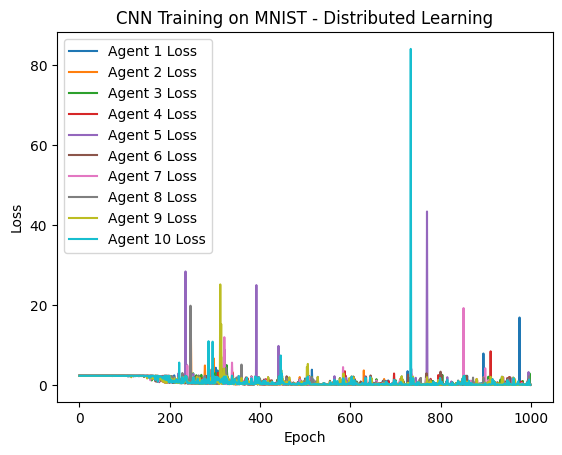

In [8]:
# plot
for i in range(num_agents):
    plt.plot(losses[i], label=f"Agent {i+1} Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Training on MNIST - Distributed Learning")
plt.legend()
plt.show()